In [1]:
# работа с таблицами
import numpy as np
import pandas as pd

# работа с графиками
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# вспомогательные методы
from IPython.display import display
from transliterate import translit
import warnings

### Функции

In [2]:
# анализ категорий, неявных дубликатов и ошибок (явных аномалий) в данных
def quick_look(df:pd.DataFrame,name:str="") -> None:

    result = pd.concat((
        df.dtypes.to_frame(name="dtype").T,
        df.nunique().to_frame(name="nunique").T,
        round((df.apply(pd.Series.duplicated).sum() / df.count()).to_frame(name="duplicates").T,2),
        round(df.isna().mean().to_frame(name="NA").T,2),
        pd.DataFrame([["─"] * df.shape[1] ],columns=df.columns,index=["─ ex:"]),
        df.head(1),
        df.iloc[1:-2].sample(1),
        df.tail(1),
        pd.DataFrame([["─"] * df.shape[1]],columns=df.columns,index=["─ m:"]),
        df.min().to_frame(name="min").T,
        df.loc[:,df.dtypes != object].mean().to_frame(name="mean").T,
        df.max().to_frame(name="max").T,
    ))

    result.index.name = name

    return result

### Загрузка датасета

In [3]:
df_clients = pd.read_excel('Выгрузка для ЯП_2.xlsx', sheet_name='Доноры')
df_payments = pd.read_excel('Выгрузка для ЯП_2.xlsx', sheet_name='Пожертвования')

In [4]:
df_clients = df_clients.rename(columns={"Дата последней email активности":"email_action",'Город':'city','Пол':'gender_male'})

df_clients_gend = sorted(df_clients.gender_male.dropna().unique())
df_clients.gender_male = df_clients.gender_male.replace({val:i for i, val in enumerate(df_clients_gend)})

In [5]:
df_payments = df_payments\
    .rename(columns=
            {"Donor ID":"ID",
            'Дата платежа':'pay_date',
            'Рекуррентный':'recurrentis',
            'Сумма платежа':'pay_sum',
            'Назначение платежа':'pay_purpose',
            'Канал оплаты':'pay_method'})
df_payments_rec = sorted(df_payments.recurrentis.unique(),reverse=True)
df_payments.recurrentis = df_payments.recurrentis.replace({val:i for i, val in enumerate(df_payments_rec)})

df_payments.pay_method = df_payments.pay_method.str.strip().str.lower()

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    display(quick_look(df_clients))

,ID,gender_male,city,email_action
,,,,
dtype,object,float64,object,datetime64[ns]
nunique,3683,2,234,653
duplicates,0.0,1.51,3.4,1.65
NA,0.0,0.34,0.72,0.5
─ ex:,─,─,─,─
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaN
2887,8995E668-1C2F-463D-B504-C87AACEF5D25,NaN,NaN,2022-05-03 00:05:50
3682,B7B85C92-A071-4D15-A8AD-FFF3107199DA,0.0,Волгоград,2020-10-08 17:42:07
─ m:,─,─,─,─


In [7]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    display(quick_look(df_payments))

,ID,pay_date,pay_sum,recurrentis,pay_purpose,pay_method
,,,,,,
dtype,object,datetime64[ns],float64,int64,object,object
nunique,3683,13386,373,2,893,4
duplicates,0.74,0.05,0.97,1.0,1.03,1.0
NA,0.0,0.0,0.0,0.0,0.09,0.0
─ ex:,─,─,─,─,─,─
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,1,ПОЖЕРТВОВАНИЕ undefined,банковские карты
8278,F4499862-D3B4-4C55-AFCB-94AE328456DE,2021-11-29 17:41:02,2000.0,0,На тьютора Косте,банковские карты
14042,EAD75CE6-0F33-478E-A37E-712C66DB9082,2020-05-27 22:49:33,10000.0,1,ПОЖЕРТВОВАНИЕ,банковские карты
─ m:,─,─,─,─,─,─


In [8]:
#смотрим, совпадают ли ID
set(df_payments.ID) - set(df_clients.ID), set(df_clients.ID) - set(df_payments.ID)

(set(), set())

## Подготовка

In [9]:
purp_replaces = {
    "фонд":['пожертвование',
        'пожертвование в фонд помощи детям-отказникам и детям-сиротам "бюро добрых дел"',
        'пожертвование  undefined',
        'добровольное пожертвование. ндс не облагается',
        'пожертвование без назначения',
        'на работу фонда',
        'добровольное пожертвование',
        'добровольный взнос',
        'благотворительное пожертвование. ндс не облагается',
        'благотворительность',
        'помощь',
        'помощь',
        'благотворительное пожертвование',
        'благотворительность ',
        'благотворительный взнос',
        'пожертвование  всем',
        'пожертвование  ',
        'пожертвование',
        'благотворительный взнос',
        'пожертвование',
        'детям',
        'добровольное пожертвование',
        '6162;61 62;сумма 100 руб.;комиссия 0 руб;дата оплаты 09/05/2019;',],
    "фонд.смс":['sms bdd'],
    "фонд.клуб_друзей":['пожертвование клуб друзей'],
    "фонд.ресурсный_центр":['на ресурсный центр'],
    "фонд.окно_в_мир":['на программу окно в мир']
}

purp_conditions = {
    "целевой.обучение":["на обучение","На обучение","Московские каникулы","На тьютора","обучение "],
    "целевой.псих_помощь":["На психологическую помощь"], 
    "целевой.проживание":["На проживание",],
    "фонд.соц_квартиры":["Соц.квартиры","Социальные квартиры","соц.квартиры","соц.квартира",'социальные гостиницы'],
    "фонд.история_успеха":["История успеха"],
    "фонд.школа_семьи":["Школа семьи"],
    "фонд.окно_в_мир":['Окно в мир'],
    "фонд.трудоустройство":['На трудоустройство','успешное будущее','путевка в будущее'],
    "фонд.центр_профориентации":["Центр профориентации"],
    "фонд.дети_вместо_цветов":['Дети вместо цветов'],
    "фонд.подари_профессию":['Подари профессию','будующая профессия','будущая профессия','найти себя'],
    "фонд.ресурсный_центр":['Ресурсного центра','ресурс'],
    "фонд.школа_нетрудных_подростков":['нетрудных подростков','школа подростков'],
    "фонд.живые_мечты":['живые мечты'],
    "фонд.детский_дом":["детскому дому","детских домов","детский дом",'детского дома'],
    "возврат":[ 'возврат',"ВОЗВРАТ НЕИСПОЛЬЗОВАННЫХ СРЕДСТВ","Возврат неиспользованных денежных средств",
                'Возврат ошибочно переведенных средств', 'Возврат средств'],
    "целевой":[ "День рождения со смыслом","Артём","Артем","Ксении","Февронии","Вере","Андрея","Саша","Лиза","Алина","Юре",
                "Софья", "Глеба", "Саше", "Катя", "для ","Амиру","стасу",],  
    "фонд":['Пожертвование в БЛАГОТВОРИТЕЛЬНЫЙ ФОНД ПОМОЩИ ДЕТЯМ-ОТКАЗНИКАМ И ДЕТЯМ-СИРОТАМ',"отказникам","на ",
            'БЛАГОТВОРИТЕЛЬНОЕ ПОЖЕРТВОВАНИЕ','оплата по договору',"пополнение","добровольное пожертвование",
            'благотворительный взнос;','перевод с карты','разово','пожертвование','благотворительный взнос'],
}
temp_series = df_payments.pay_purpose.str.lower().str.strip()

for target, values in purp_conditions.items():
    for value in values:
        temp_series.loc[temp_series.str.contains(value.lower()).fillna(False)] = target

for target, values in purp_replaces.items():
    temp_series = temp_series.replace(values,target)

df_payments['pay_purpose_category'] = temp_series

df_payments.loc[df_payments.pay_method == "sms",'pay_purpose_category'] = 'фонд.смс'
df_payments.loc[df_payments.pay_purpose.isna(),'pay_purpose_category'] = 'фонд'
df_payments.loc[df_payments.pay_purpose == 500,'pay_purpose_category'] = 'фонд'

print(df_payments['pay_purpose_category'].value_counts(dropna=False))

df_payments['pay_purpose_cat'] = None

cat_trans = {'фонд':'general','целевой':'telic','возврат':'return'}

for cat in ['фонд','целевой','возврат']:
    mask = df_payments['pay_purpose_category'].str.startswith(cat)
    df_payments.loc[mask.fillna(False),'pay_purpose_cat'] = cat_trans[cat]

print("-"*50,"\n",df_payments.pay_purpose_cat.value_counts(dropna=False))

print("-"*50,"\n",f'Осталось необработано: {df_payments.pay_purpose_cat.isna().sum():.0f} строк')

фонд                               12165
целевой.обучение                     977
фонд.смс                             253
целевой                              236
целевой.проживание                    97
целевой.псих_помощь                   51
фонд.окно_в_мир                       45
фонд.история_успеха                   41
фонд.ресурсный_центр                  37
фонд.школа_семьи                      36
возврат                               26
фонд.соц_квартиры                     26
фонд.трудоустройство                  20
фонд.подари_профессию                  8
фонд.дети_вместо_цветов                8
фонд.детский_дом                       6
фонд.школа_нетрудных_подростков        6
фонд.живые_мечты                       4
фонд.центр_профориентации              1
Name: pay_purpose_category, dtype: int64
-------------------------------------------------- 
 general    12656
telic       1361
return        26
Name: pay_purpose_cat, dtype: int64
----------------------------------------

In [10]:
# для динамики и сезонности
df_payments['pay_hour'] = df_payments.pay_date.dt.hour
df_payments['pay_day'] = df_payments.pay_date.dt.day
df_payments['pay_dayofweek'] = df_payments.pay_date.dt.dayofweek
df_payments['pay_dayofweek'] += 1
df_payments['pay_month'] = df_payments.pay_date.dt.month
df_payments['pay_year'] = df_payments.pay_date.dt.year

# убираем возвраты и крупные суммы
df_payments_noret = df_payments.query(f'pay_purpose_cat != "return" and pay_sum <= {df_payments.pay_sum.quantile(.985)}')

In [11]:
# возвраты это минус
df_payments.loc[df_payments.pay_purpose_cat == "return","pay_sum"] *= -1

In [12]:
df_payments.sample()

,ID,pay_date,pay_sum,recurrentis,pay_purpose,pay_method,pay_purpose_category,pay_purpose_cat,pay_hour,pay_day,pay_dayofweek,pay_month,pay_year
13761,13B7DCC2-6105-4A9A-AFE5-0C4F24EC4A2D,2021-04-25 18:29:31,1000.0,1,ПОЖЕРТВОВАНИЕ undefined,банковские карты,фонд,general,18,25,7,4,2021


In [13]:
df_clients.gender_male = (df_clients.gender_male * 2 - 1).fillna(0).astype(int)

In [14]:
df_clients.city = df_clients.city.str.lower().fillna('NA')

## EDA

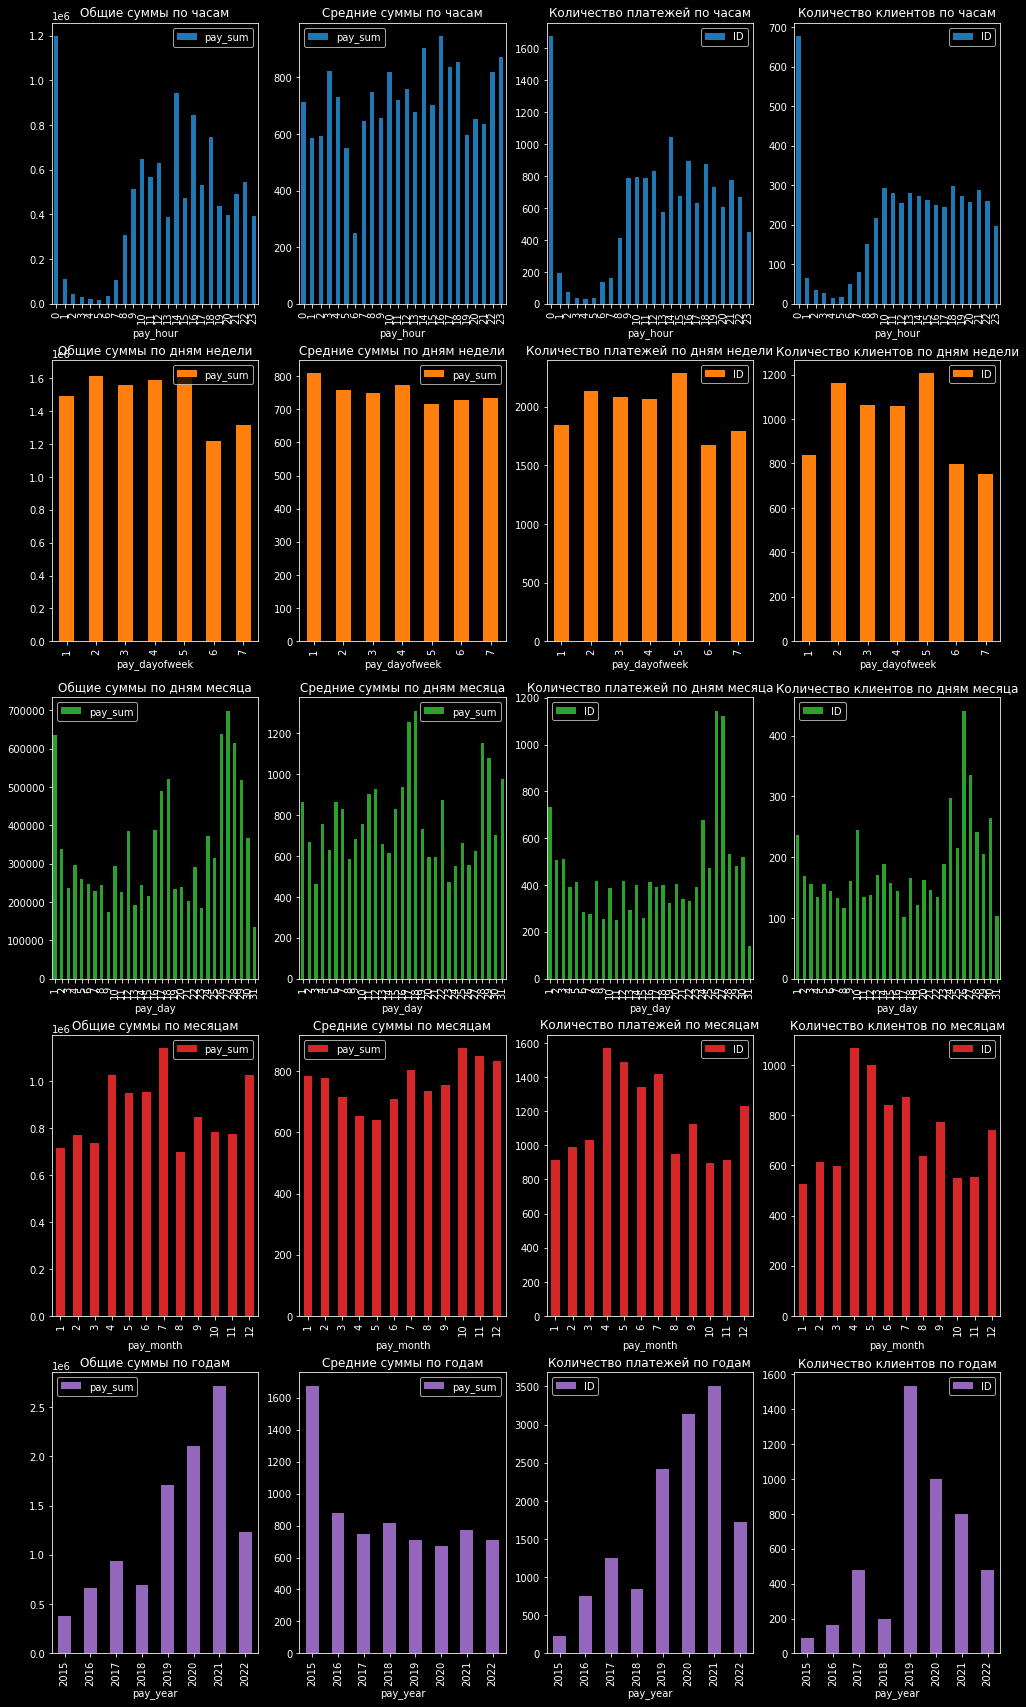

In [15]:
def template_dict(val_str):
    return {
        f"Общие суммы по {val_str}":{"pay_sum":"sum"},
        f"Средние суммы по {val_str}":{"pay_sum":"mean"},
        f"Количество платежей по {val_str}":{"ID":"count"},
        f"Количество клиентов по {val_str}":{"ID":"nunique"}}

grpby_dict = {
    'pay_hour': template_dict('часам'),
    'pay_dayofweek' : template_dict('дням недели'),
    'pay_day': template_dict('дням месяца'),
    'pay_month': template_dict('месяцам'),
    'pay_year': template_dict('годам'),
}

fig, axs = plt.subplots(nrows= len(grpby_dict), ncols=4,figsize=(17,30))
cmap = matplotlib.cm.get_cmap('tab10')

for i, (grpby, conditions) in enumerate(grpby_dict.items()):
    for j, (title,agg_func) in enumerate(conditions.items()):
        df_payments_noret.groupby(grpby).agg(agg_func).plot.bar(color=cmap(i),ax=axs[i][j]).set(title=title)

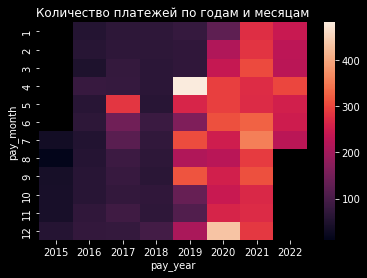

In [16]:
sns.heatmap(df_payments_noret.pivot_table(values="ID",aggfunc="count",index='pay_month',columns='pay_year'))\
   .set(title="Количество платежей по годам и месяцам");

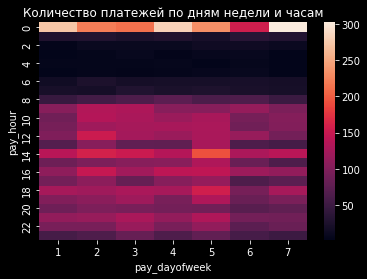

In [17]:
sns.heatmap(df_payments_noret.pivot_table(values="ID",aggfunc="count",index='pay_hour',columns='pay_dayofweek'))\
   .set(title="Количество платежей по дням недели и часам");

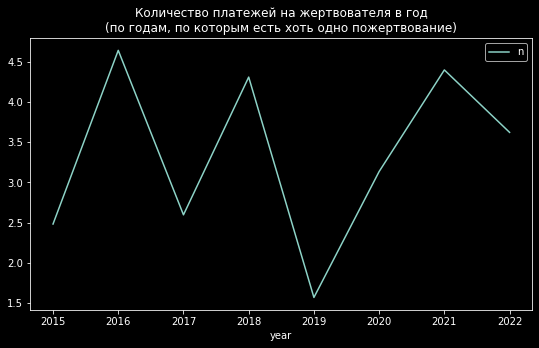

In [18]:
y_pays = df_payments_noret.groupby(["ID",'pay_year'])\
    .agg({"pay_sum":["count","mean","sum"]})\
    .reset_index().set_axis(['ID','year',"n","mean_sum","sum"],axis=1)
y_pays.groupby('year').agg({"n":"mean"}).plot(figsize=(9,5))\
    .set(title="Количество платежей на жертвователя в год\n(по годам, по которым есть хоть одно пожертвование)");

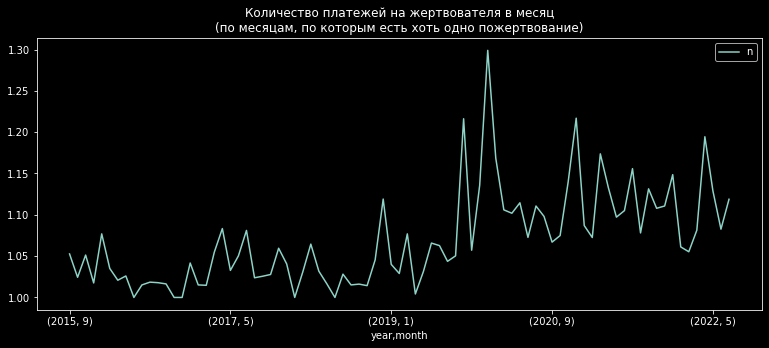

In [19]:
y_pays2 = df_payments_noret.groupby(['pay_year','pay_month',"ID"])\
    .agg({"pay_sum":["count","mean","sum"]})\
    .reset_index().set_axis(['year','month','ID',"n","mean_sum","sum"],axis=1)
y_pays2.query('year >= 2016 or month >= 9').groupby(['year','month']).agg({"n":"mean"}).plot(figsize=(13,5))\
    .set(title="Количество платежей на жертвователя в месяц\n(по месяцам, по которым есть хоть одно пожертвование)");

In [20]:
df_payments_noret.sample()

,ID,pay_date,pay_sum,recurrentis,pay_purpose,pay_method,pay_purpose_category,pay_purpose_cat,pay_hour,pay_day,pay_dayofweek,pay_month,pay_year
11401,865FF01A-0F5E-463D-9DE6-91C2202F868D,2020-10-03 10:22:56,500.0,1,ПОЖЕРТВОВАНИЕ,банковские карты,фонд,general,10,3,6,10,2020


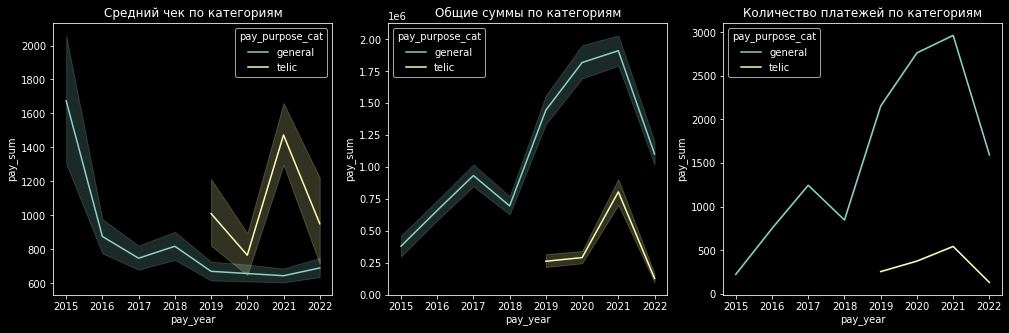

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(17,5))

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='pay_purpose_cat',ax=axs[0])\
    .set(title='Средний чек по категориям')

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='pay_purpose_cat',estimator='sum',ax=axs[1])\
    .set(title='Общие суммы по категориям')

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='pay_purpose_cat',estimator=len,ax=axs[2])\
    .set(title='Количество платежей по категориям');

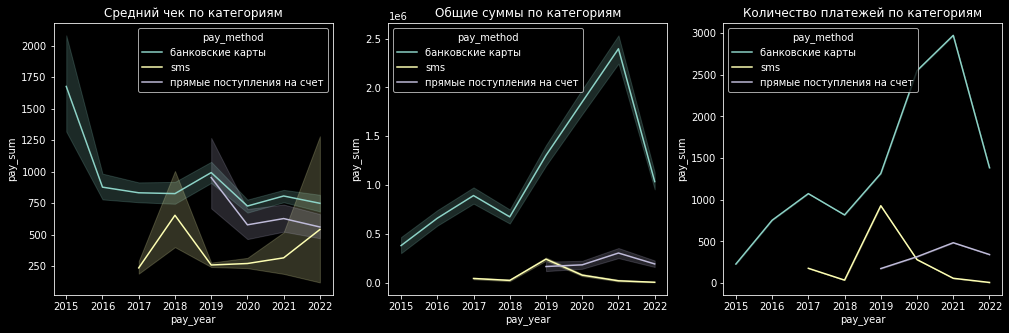

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(17,5))

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='pay_method',ax=axs[0])\
    .set(title='Средний чек по категориям')

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='pay_method',estimator='sum',ax=axs[1])\
    .set(title='Общие суммы по категориям')

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='pay_method',estimator=len,ax=axs[2])\
    .set(title='Количество платежей по категориям');

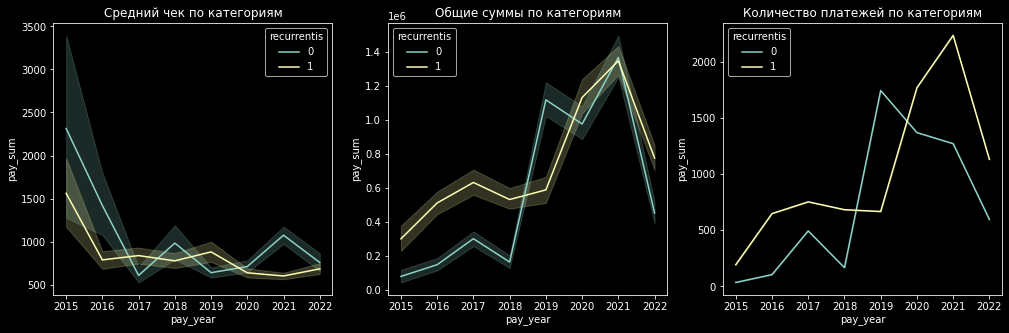

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(17,5))

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='recurrentis',ax=axs[0])\
    .set(title='Средний чек по категориям')

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='recurrentis',estimator='sum',ax=axs[1])\
    .set(title='Общие суммы по категориям')

sns.lineplot(data=df_payments_noret,x='pay_year',y="pay_sum",hue='recurrentis',estimator=len,ax=axs[2])\
    .set(title='Количество платежей по категориям');

In [24]:
df_payments['pay_dt'] = df_payments.pay_date.dt.date
first_pays = df_payments.sort_values('pay_dt').groupby('ID').agg({'pay_dt':'first'}).set_axis(['first_pay'],axis=1)
df_payments_lt = df_payments.join(first_pays,on="ID")
df_payments_lt['lt'] = (df_payments_lt.pay_dt - df_payments_lt.first_pay).dt.days
df_payments_lt.drop(['pay_date','pay_purpose','pay_purpose_category'],axis=1,inplace=True)
df_payments_lt = df_payments_lt.sort_values('pay_dt')


In [25]:
df_payments_lt = df_payments_lt.join(df_payments_lt.groupby('ID').agg({'pay_sum':'cumsum'}).set_axis(['cumul_sum'],axis=1))

In [26]:
df_payments_lt.sample()

,ID,pay_sum,recurrentis,pay_method,pay_purpose_cat,pay_hour,pay_day,pay_dayofweek,pay_month,pay_year,pay_dt,first_pay,lt,cumul_sum
3444,D9AFA244-944E-45AE-B15E-162550197781,300.0,1,банковские карты,general,14,17,3,7,2019,2019-07-17,2017-12-17,577,6000.0


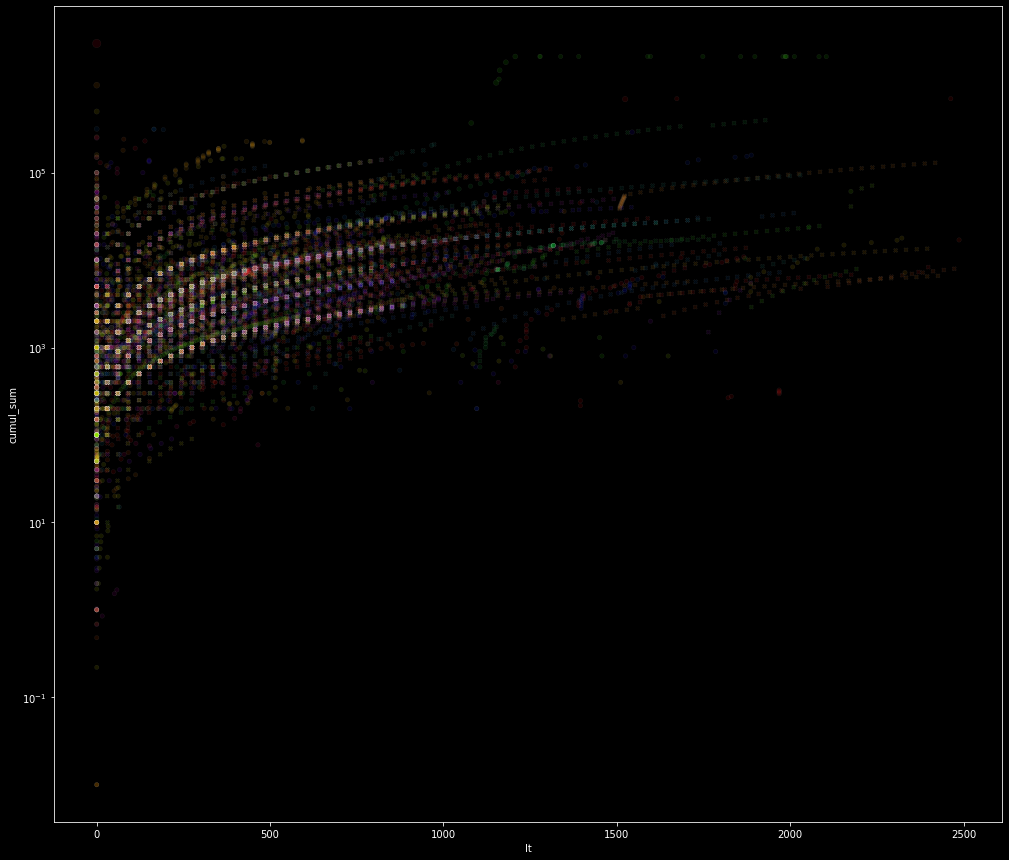

In [27]:
plt.figure(figsize=(17,15))
sns.scatterplot(data=df_payments_lt,x='lt',y='cumul_sum',size='pay_sum',style='recurrentis',hue='ID',alpha=.1,legend = False,palette="prism")
plt.yscale('log');

d:\Media\Repo\Miniconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


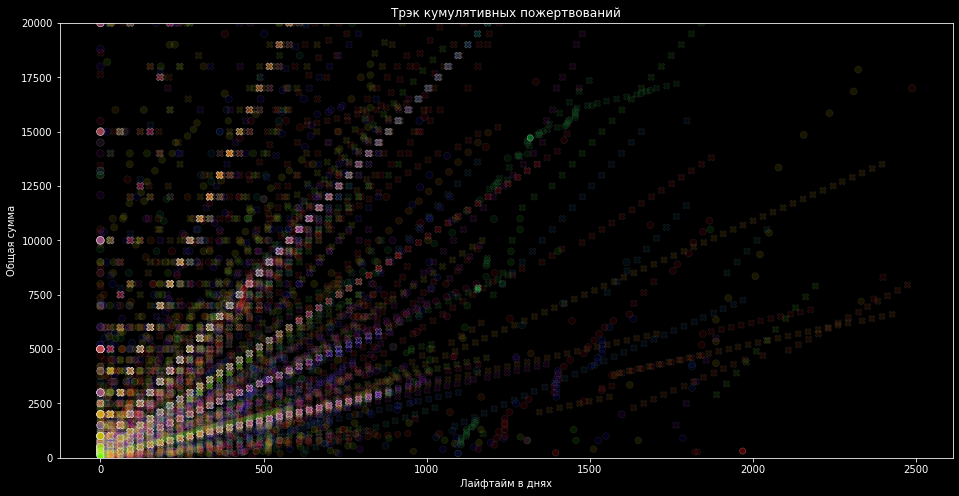

In [28]:
fig = plt.figure(figsize=(16,8))
ax = sns.scatterplot(
   data=df_payments_lt.assign(pay_sum_log = np.log(df_payments_lt.pay_sum)),
   x='lt',y='cumul_sum',size='pay_sum_log',style='recurrentis',hue='ID',alpha=.1,legend = False,palette="prism")
ax.set(title="Трэк кумулятивных пожертвований",ylabel="Общая сумма",xlabel="Лайфтайм в днях",ylim=(0,20_000));

In [29]:
# готовим данные к выгрузке
df_payments_lt.pay_method = df_payments_lt.pay_method.map({'банковские карты':'cards', 'sms':'sms', 'прямые поступления на счет':'account',
       'наличные в кассу':'cash'})
df_payments_out = df_payments_lt[['ID', 'pay_dt', 'pay_sum', 'recurrentis', 'pay_method', 'pay_purpose_cat',
       'pay_hour']]
df_payments_out = df_payments_out.rename(columns={"ID":"client_id"})

neg_clients = df_payments_out.groupby('client_id').agg({'pay_sum':'sum'}).query('pay_sum < 0').index

df_payments_out = df_payments_out.query('client_id not in @neg_clients')
df_clients_out = df_clients.query('ID not in @neg_clients')

In [30]:
df_clients.to_csv('df_clients.csv')
df_payments_out.to_csv('df_payments.csv')